# The Office 
##### Analysis of lines spoken over 9 seasons

In [248]:
#Import necessary libraries and data file

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize


# Source: Reddit, https://www.reddit.com/r/datasets/comments/6yt3og/every_line_from_every_episode_of_the_office_us/
url = 'https://raw.githubusercontent.com/clairemasse/theoffice/master/theofficelines.csv'
theoffice = pd.read_csv(url, index_col='id')
print(theoffice.head(10))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
    season  episode  ...  speaker deleted
id                   ...                 
1        1        1  ...  Michael   False
2        1        1  ...      Jim   False
3        1        1  ...  Michael   False
4        1        1  ...      Jim   False
5        1        1  ...  Michael   False
6        1        1  ...  Michael   False
7        1        1  ...  Michael   False
8        1        1  ...      Pam   False
9        1        1  ...  Michael   False
10       1        1  ...      Pam   False

[10 rows x 6 columns]


In [249]:
# drop deleted scenes
deletedscenes = (theoffice['deleted'] == True)
theoffice.drop(index=theoffice[deletedscenes].index, inplace=True)
theoffice.drop(['deleted'], axis=1, inplace=True)

num_lines = len(theoffice)
print('Excluding deleted scenes, there are ' +
      str(num_lines) + ' lines in the dataframe.')

Excluding deleted scenes, there are 57973 lines in the dataframe.


In [250]:
# fix incorrectly formatted apostrophes in line_text column
lines = theoffice['line_text']
lines.str.replace('���', "'")

#Check
'���' in lines

False

In [0]:
#Consolidate duplicate characters

theoffice['speaker'].replace('Deangelo','DeAngelo', inplace=True)
theoffice['speaker'].replace('Packer','Todd Packer', inplace=True)

In [252]:
# Add a column to the dataframe with number of words in each line
def numwords(line):
    return len(line.split(" "))


theoffice['length'] = theoffice['line_text'].apply(numwords)
print(theoffice.head())

    season  episode  ...  speaker length
id                   ...                
1        1        1  ...  Michael     14
2        1        1  ...      Jim      9
3        1        1  ...  Michael     14
4        1        1  ...      Jim      8
5        1        1  ...  Michael     10

[5 rows x 6 columns]


In [253]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()

sentiments = []
for line in lines:
    ss = sid.polarity_scores(line)['compound']
    sentiments.append(ss)

theoffice['sentiment'] = sentiments

theoffice.head()

,season,episode,scene,line_text,speaker,length,sentiment
id,,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,14,0.4927
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,9,0.0000
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,14,0.0000
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,8,0.4215
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,10,0.2732


In [0]:
# initial look at data by speaker/character
speaker_col = theoffice['speaker']
characters = pd.DataFrame(speaker_col.value_counts())
characters.reset_index(inplace=True)
characters.rename(columns={'index': 'speaker',
                           'speaker': 'num_lines'}, inplace=True)
# we only want to look at recurring characters -- drop speakers with fewer than 100 lines throughout the whole series
fewlines = characters.loc[:, 'num_lines'] < 100
characters.drop(index=characters[fewlines].index, inplace=True)

# scanning above data, we notice speakers 'All' and 'Everyone' which don't represent specific characters - let's drop those
not_people = ['All', 'Everyone']
all = characters.loc[:, 'speaker'].str.contains('|'.join(not_people))
characters.drop(index=characters[all].index, inplace=True)



In [255]:

# drop rows from original dataframe to match those we dropped in speakers df
keepspeakers = ~theoffice['speaker'].isin(characters['speaker'])
theoffice.drop(index=theoffice[keepspeakers].index, inplace=True)

# add num_lines column into theoffice dataframe
theoffice = pd.merge(theoffice, characters, on='speaker')
# Calculate average length of line for each person
avg_words = pd.DataFrame(theoffice.groupby('speaker')[
                         'length'].mean().round()).reset_index()
characters['avg_words'] = avg_words['length']
print(characters.head())

print(len(theoffice))

   speaker  num_lines  avg_words
0  Michael      11574       13.0
1   Dwight       7167        9.0
2      Jim       6609        9.0
3      Pam       5205       10.0
4     Andy       3969       11.0
53165


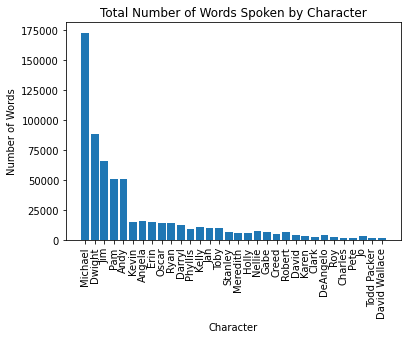

In [256]:
# Let's see how many words each character spoke
listcharacters = characters['speaker'].tolist()


def totalwords(character):
    rows = (theoffice.loc[theoffice['speaker'] == character, 'length'])
    totalwords = rows.sum()
    return totalwords


characterwords = []
for character in listcharacters:
    characterwords.append(totalwords(character))


y_pos = np.arange(len(listcharacters))
plt.bar(y_pos, characterwords)
plt.xlabel('Character')
plt.xticks(y_pos, listcharacters, rotation='vertical')
plt.ylabel('Number of Words')
plt.title('Total Number of Words Spoken by Character')
plt.show()


     speaker  Average Line Length
15        Jo            15.953608
8   DeAngelo            15.780000
20   Michael            14.912995
11      Gabe            14.651376
26    Robert            14.646512


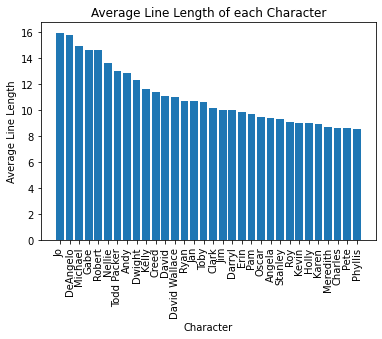

In [257]:

avglength = theoffice.groupby('speaker')['length'].mean().rename('Average Line Length').reset_index()
avglength = avglength.sort_values(by='Average Line Length', ascending=False)

print(avglength.head())

listcharacters = avglength['speaker'].tolist()
y_pos = np.arange(len(listcharacters))
length = avglength['Average Line Length'].tolist()


plt.bar(y_pos, length)
plt.xlabel('Character')
plt.ylabel('Average Line Length')
plt.xticks(y_pos, listcharacters, rotation='vertical')
plt.title('Average Line Length of each Character')
plt.show()


     speaker  Average Sentiment
3      Clark           0.172949
6      David           0.172553
8   DeAngelo           0.161588
16     Karen           0.150811
20   Michael           0.147260


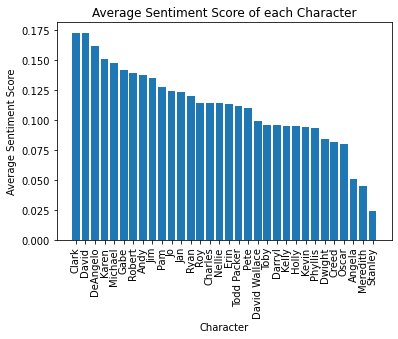

In [258]:
#Average sentiment per character

avgsent = theoffice.groupby('speaker')['sentiment'].mean().rename('Average Sentiment').reset_index()
avgsent = avgsent.sort_values(by='Average Sentiment', ascending=False)

print(avgsent.head())

listcharacters = avgsent['speaker'].tolist()
y_pos = np.arange(len(listcharacters))
length = avgsent['Average Sentiment'].tolist()


plt.bar(y_pos, length)
plt.xlabel('Character')
plt.ylabel('Average Sentiment Score')
plt.xticks(y_pos, listcharacters, rotation='vertical')
plt.title('Average Sentiment Score of each Character')
plt.show()